In [1]:
import torch
import numpy as np
from experiments.utils import pickle_read
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from torchvision.utils import make_grid

from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.progress import ProgressBar
import pytorch_lightning as pl
from neuralpredictors.measures.modules import Corr, PoissonLoss
from torch.nn import Parameter
from energy_model.lucas_gabor_filter import GaborFilter
from energy_model.utils import plot_f, create_grating
from energy_model.energy_model import EnergyModel


In [2]:

ENTITY = "csng-cuni"
PROJECT = "reCNN_visual_prosthesis"
ground_truth_positions_file_path = "data/antolik/position_dictionary.pickle"
ground_truth_orientations_file_path = "data/antolik/oris.pickle"

model = None

config = {
    # GENERAL
    "seed": 42,
    "batch_size": 500,
    "lr": 0.01,
    "max_epochs": 5,

    # CORE GENERAL CONFIG
    "core_hidden_channels": 8,
    "core_layers": 5,
    "core_input_kern": 7,
    "core_hidden_kern": 9,

    # ROTATION EQUIVARIANCE CORE CONFIG
    "num_rotations": 8,       
    "stride": 1,               
    "upsampling": 2,           
    "rot_eq_batch_norm": True, 
    "stack": -1 ,               
    "depth_separable": True,

    # READOUT CONFIG
    "readout_bias": False,
    "nonlinearity": "softplus",
    
    # REGULARIZATION
    "core_gamma_input": 0.00307424496692959,
    "core_gamma_hidden": 0.28463619129195233,
    "readout_gamma": 0.17,
    "input_regularizer": "LaplaceL2norm", # for RotEqCore - default 
    "use_avg_reg": True,

    "reg_readout_spatial_smoothness": 0.0027,
    "reg_group_sparsity": 0.1,
    "reg_spatial_sparsity": 0.45,

    # TRAINER
    "patience": 40,
    "train_on_val": True, # in case you want to quickly check that your model "compiles" correctly
    "test": True,
    "observed_val_metric": "val/corr",

    "test_average_batch": False,
    "compute_oracle_fraction": False,
    "conservative_oracle": True,
    "jackknife_oracle": True,
    "generate_oracle_figure": False,

    # ANTOLIK
    "region": "region1",
    "dataset_artifact_name": "Antolik_dataset:latest",

    # BOTTLENECK
    "bottleneck_kernel": 15,

    "fixed_sigma": False,
    "init_mu_range": 0.9,
    "init_sigma_range": 0.8,

}

In [3]:
from Antolik_dataset import AntolikDataModule

path_train = "/storage/brno2/home/mpicek/reCNN_visual_prosthesis/data/antolik/one_trials.pickle"
path_test = "/storage/brno2/home/mpicek/reCNN_visual_prosthesis/data/antolik/ten_trials.pickle"

dataset_config = {
    "train_data_dir": path_test,
    "test_data_dir": path_test,
    "batch_size": config["batch_size"],
    "normalize": True,
    "val_size": 500,
    "brain_crop": 0.8,
    "stimulus_crop": "auto",
    # "stimulus_crop": [110, 110],
    "ground_truth_path": "data/antolik/position_dictionary.pickle",
}


In [4]:
dm = AntolikDataModule(**dataset_config)


12px will be discarded from each side.


In [5]:
dm.prepare_data()
dm.setup()

Data loaded successfully!


In [6]:
config.update(
        {
            "input_channels": dm.get_input_shape()[0],
            "input_size_x": dm.get_input_shape()[1],
            "input_size_y": dm.get_input_shape()[2],
            "num_neurons": dm.get_output_shape()[0],
            "mean_activity": dm.get_mean(),
            "filtered_neurons":dm.get_filtered_neurons(),
        }
    )

Loaded precomputed mean from /storage/brno2/home/mpicek/reCNN_visual_prosthesis/data/antolik/ten_trials_mean.npy


In [7]:

resolution = (dm.get_input_shape()[1], dm.get_input_shape()[2])
xlim = [-dm.get_stimulus_visual_angle()/2, dm.get_stimulus_visual_angle()/2]
ylim = [-dm.get_stimulus_visual_angle()/2, dm.get_stimulus_visual_angle()/2]

pos_x, pos_y, orientations = dm.get_ground_truth(ground_truth_positions_file_path, ground_truth_orientations_file_path)

model = EnergyModel(pos_x, pos_y, orientations, resolution, xlim, ylim, default_ori_shift=90, learning_rate=0.01, counter_clockwise_rotation=True, multivariate=True, **config)


/opt/conda/lib/python3.8/site-packages/neuralpredictors/measures/modules.py:78: UserWarning: Poissonloss is averaged per batch. It's recommended to use `sum` instead
  warnings.warn("Poissonloss is averaged per batch. It's recommended to use `sum` instead")


In [8]:
config.update(
    {
        "ground_truth_positions_file_path": "data/antolik/position_dictionary.pickle",
        "ground_truth_orientations_file_path": "data/antolik/oris.pickle",
        "init_to_ground_truth_positions": True,
        "init_to_ground_truth_orientations": True,
        "freeze_positions": False,
        "freeze_orientations": False,
        "orientation_shift": 87.4,
        "factor": 5.5,
        "sample": False,
        "filtered_neurons":None,
    }
)

In [9]:


early_stopping_monitor="val/corr"
early_stopping_mode="max"
model_checkpoint_monitor="val/corr"
model_checkpoint_mode="max"

use_wandb = True


In [10]:
import wandb
from Lurz_dataset import LurzDataModule

from models import reCNN_FullFactorized
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.progress import ProgressBar
import pytorch_lightning as pl
from models import reCNN_bottleneck_CyclicGauss3d
from pprint import pprint
from Antolik_dataset import AntolikDataModule

if use_wandb:

    pl.seed_everything(config["seed"], workers=True)

    model_artifact_name = None

    # init wandb run
    run = wandb.init(
        config=config,
        project=PROJECT,
        entity=ENTITY,
    )

    # Access all hyperparameter values through wandb.config
    config = dict(wandb.config)
    pprint(config)


    # setup wandb logger
    wandb_logger = WandbLogger(log_model=True)
    wandb_logger.watch(model, log="all", log_freq=250)

    # define callbacks for the training
    early_stop = EarlyStopping(
        monitor=early_stopping_monitor,
        patience=config["patience"],
        mode=early_stopping_mode,
    )
    checkpoint_callback = ModelCheckpoint(
        save_top_k=1, monitor=model_checkpoint_monitor, mode=model_checkpoint_mode
    )

    class LitProgressBar(ProgressBar):
        def get_metrics(self, trainer, model):
            # don't show the version number
            items = super().get_metrics(trainer, model)
            items.pop("v_num", None)
            return items

    bar = LitProgressBar()


    # define the trainer
    trainer = pl.Trainer(
        callbacks=[early_stop, checkpoint_callback, bar],
        max_epochs=config["max_epochs"],
        gpus=[0],
        logger=wandb_logger,
        log_every_n_steps=1,
        # deterministic=True,
        enable_checkpointing=True,
    )


    trainer.fit(
        model,
        train_dataloaders=dm.train_dataloader(),
        val_dataloaders=dm.val_dataloader(),
        )

    best_observed_val_metric = (
        checkpoint_callback.best_model_score.cpu().detach().numpy()
    )
    print(
        "Best model's "
        + config["observed_val_metric"]
        + ": "
        + str(best_observed_val_metric)
    )

    if model_artifact_name == None:
        model_artifact_name = model.__str__()

    # add best corr to metadata
    metadata = {**config, "best_model_score": best_observed_val_metric}

    # add model artifact
    best_model_artifact = wandb.Artifact(
        model_artifact_name, type="model", metadata=metadata
    )
    best_model_artifact.add_file(checkpoint_callback.best_model_path)
    run.log_artifact(best_model_artifact)

    # say to wandb that the best val/corr of the model is the best one
    # and not the last one!! (it is the default behavour!!)
    run.summary[config["observed_val_metric"]] = best_observed_val_metric

    print(checkpoint_callback.best_model_path)

    model = EnergyModel.load_from_checkpoint(checkpoint_callback.best_model_path)

    if config["test"]:
        dm.model_performances(model, trainer)



        # result_artifact = wandb.Artifact(name="RESULT_" + model_artifact_name, type="result",
        #     metadata=results[0])
        # run.log_artifact(result_artifact)

else:
    pl.seed_everything(config["seed"], workers=True)
    pprint(config)


    # define callbacks for the training
    early_stop = EarlyStopping(
        monitor=early_stopping_monitor,
        patience=config["patience"],
        mode=early_stopping_mode,
    )
    checkpoint_callback = ModelCheckpoint(
        save_top_k=1, monitor=model_checkpoint_monitor, mode=model_checkpoint_mode
    )

    class LitProgressBar(ProgressBar):
        def get_metrics(self, trainer, model):
            # don't show the version number
            items = super().get_metrics(trainer, model)
            items.pop("v_num", None)
            return items

    bar = LitProgressBar()

    # define the trainer
    trainer = pl.Trainer(
        callbacks=[early_stop, checkpoint_callback, bar],
        max_epochs=config["max_epochs"],
        gpus=[0],
        # logger=wandb_logger,
        log_every_n_steps=1,
        # deterministic=True,
        enable_checkpointing=True,
    )

    if config["train_on_val"]:
        trainer.fit(
            model,
            train_dataloaders=dm.val_dataloader(),
            val_dataloaders=dm.val_dataloader(),
        )

    else:
        trainer.fit(
            model,
            train_dataloaders=dm.train_dataloader(),
            val_dataloaders=dm.val_dataloader(),
        )

    best_observed_val_metric = (
        checkpoint_callback.best_model_score.cpu().detach().numpy()
    )
    print(
        "Best model's "
        + config["observed_val_metric"]
        + ": "
        + str(best_observed_val_metric)
    )

    # add best corr to metadata
    metadata = {**config, "best_model_score": best_observed_val_metric}

    print(checkpoint_callback.best_model_path)

    model = EnergyModel.load_from_checkpoint(checkpoint_callback.best_model_path)

    if config["test"]:
        dm.model_performances(model, trainer)

        # result_artifact = wandb.Artifact(name="RESULT_" + model_artifact_name, type="result",
        #     metadata=results[0])
        # run.log_artifact(result_artifact)

Global seed set to 42
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: csng-cuni (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.13.5 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


/opt/conda/lib/python3.8/site-packages/pytorch_lightning/loggers/wandb.py:341: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
/opt/conda/lib/python3.8/site-packages/pytorch_lightning/callbacks/progress/progress.py:21: LightningDeprecationWarning: `ProgressBar` has been deprecated in v1.5 and will be removed in v1.7. It has been renamed to `TQDMProgressBar` instead.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


{'batch_size': 500,
 'bottleneck_kernel': 15,
 'compute_oracle_fraction': False,
 'conservative_oracle': True,
 'core_gamma_hidden': 0.28463619129195233,
 'core_gamma_input': 0.00307424496692959,
 'core_hidden_channels': 8,
 'core_hidden_kern': 9,
 'core_input_kern': 7,
 'core_layers': 5,
 'dataset_artifact_name': 'Antolik_dataset:latest',
 'depth_separable': True,
 'factor': 5.5,
 'filtered_neurons': None,
 'fixed_sigma': False,
 'freeze_orientations': False,
 'freeze_positions': False,
 'generate_oracle_figure': False,
 'ground_truth_orientations_file_path': 'data/antolik/oris.pickle',
 'ground_truth_positions_file_path': 'data/antolik/position_dictionary.pickle',
 'init_mu_range': 0.9,
 'init_sigma_range': 0.8,
 'init_to_ground_truth_orientations': True,
 'init_to_ground_truth_positions': True,
 'input_channels': 1,
 'input_regularizer': 'LaplaceL2norm',
 'input_size_x': 86,
 'input_size_y': 86,
 'jackknife_oracle': True,
 'lr': 0.01,
 'max_epochs': 5,
 'mean_activity': '[0.236   0.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [GPU-d91b248f-32bc-d3dd-0353-fc01ae9157ea]

  | Name | Type        | Params
-------------------------------------
0 | loss | PoissonLoss | 0     
1 | corr | Corr        | 0     
-------------------------------------
5         Trainable params
0         Non-trainable params
5         Total params
0.000     Total estimated model params size (MB)


Validation sanity check:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/conda/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:452: UserWarning: Your `val_dataloader` has `shuffle=True`,it is strongly recommended that you turn this off for val/test/predict dataloaders.
  rank_zero_warn(
/opt/conda/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:110: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Validation sanity check: 100%|██████████| 1/1 [00:19<00:00, 19.15s/it]0.04785307
                                                                      

Global seed set to 42
/opt/conda/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:110: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  5.03it/s, loss=5.5]
Best model's val/corr: 0.04591286
/auto/budejovice1/mpicek/reCNN_visual_prosthesis/reCNN_visual_prosthesis/3gjbu8e3/checkpoints/epoch=0-step=8.ckpt


/opt/conda/lib/python3.8/site-packages/neuralpredictors/measures/modules.py:78: UserWarning: Poissonloss is averaged per batch. It's recommended to use `sum` instead
  warnings.warn("Poissonloss is averaged per batch. It's recommended to use `sum` instead")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [GPU-d91b248f-32bc-d3dd-0353-fc01ae9157ea]
/opt/conda/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:452: UserWarning: Your `test_dataloader` has `shuffle=True`,it is strongly recommended that you turn this off for val/test/predict dataloaders.
  rank_zero_warn(
/opt/conda/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:110: UserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 100%|██████████| 1/1 [00:00<00:00,  5.16it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [GPU-d91b248f-32bc-d3dd-0353-fc01ae9157ea]


Testing: 100%|██████████| 10/10 [00:01<00:00,  5.98it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [GPU-d91b248f-32bc-d3dd-0353-fc01ae9157ea]



Testing: 100%|██████████| 500/500 [00:14<00:00, 33.72it/s]
Validation dataset:
    Correlation: 0.0459 
Test dataset with averaged responses of repeated trials:
    Correlation: 0.1046 
    Fraction oracle conservative: 0.2383 
    Fraction oracle jackknife: 0.4154 


In [16]:
from create_ensemble import download_energy_model 

model_name_prefix="csng-cuni/reCNN_visual_prosthesis/model-"
task = "3gjbu8e3"

model = download_energy_model(model_name_prefix + task + ":v0", run)

wandb: Downloading large artifact model-3gjbu8e3:v0, 266.38MB. 1 files... Done. 0:0:0


./artifacts/model-3gjbu8e3:v0
./artifacts/model-3gjbu8e3:v0/model.ckpt
Model from ./artifacts/model-3gjbu8e3:v0/model.ckpt loaded!


93
3400
-0.7999749622359675
-0.7996747841889844


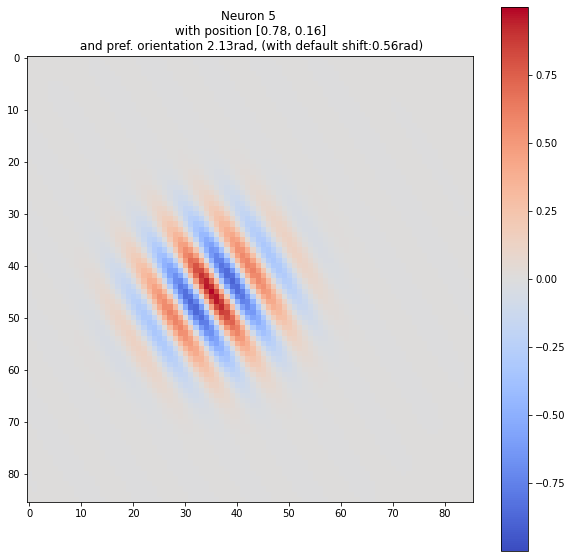

In [18]:

model.visualize(5, True, init=True)